# Séries temporelles : prévisions de la pluie à J+3 et J+7

## Récupération des librairies

In [ ]:
# récupération des librairies
%matplotlib inline

import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

## Récupération du jeu de données et analyse d'une série temporelle

In [21]:
# récupération du jeu de données
df = pd.read_csv('data/weatherAUS_preprocessed_before_city_clust.csv', 
                 header=0, index_col=0, parse_dates=[0], squeeze=True)
df.head()

,Location,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta
Date,,,,,,,,,,,
2008-12-01,Albury,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,0,9.5,-49.0
2008-12-02,Albury,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,0,17.7,-19.0
2008-12-03,Albury,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,0,12.8,-8.0
2008-12-04,Albury,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,0,18.8,-29.0
2008-12-05,Albury,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,0,14.8,-49.0


In [22]:
# taille du DataFrame
print("Nombre d'observations : {} \n Nombre de variables : {}".format(df.shape[0], df.shape[1]))

Nombre d'observations : 140787 
 Nombre de variables : 11


In [23]:
# affichage de l'index
print(df.index)

DatetimeIndex(['2008-12-01', '2008-12-02', '2008-12-03', '2008-12-04',
               '2008-12-05', '2008-12-06', '2008-12-07', '2008-12-08',
               '2008-12-09', '2008-12-10',
               ...
               '2017-06-15', '2017-06-16', '2017-06-17', '2017-06-18',
               '2017-06-19', '2017-06-20', '2017-06-21', '2017-06-22',
               '2017-06-23', '2017-06-24'],
              dtype='datetime64[ns]', name='Date', length=140787, freq=None)


In [24]:
# affichage du type de chacune des colonnes du DataFrame
print(df.dtypes)

Location              object
Rainfall             float64
Sunshine             float64
WindGustSpeed        float64
Humidity3pm          float64
Pressure9am          float64
Cloud3pm             float64
Temp3pm              float64
RainTomorrow           int64
Temp_Delta_MinMax    float64
Humidity_Delta       float64
dtype: object


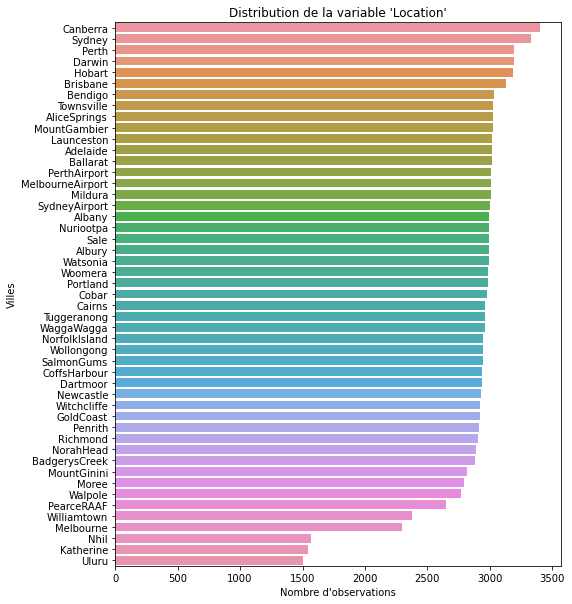

In [25]:
# distribution de la variable 'Location'
plt.figure(figsize=(8,10))
sns.countplot(y=df['Location'], order=df['Location'].value_counts().index)
plt.title("Distribution de la variable 'Location'", fontsize=12)
plt.ylabel('Villes')
plt.xlabel("Nombre d'observations");

In [26]:
# sélection des données pour la ville de Canberra
df_city = df[df["Location"] == "Canberra"]

In [27]:
# aperçu des données pour la ville de Canberra
df_city.head()

,Location,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta
Date,,,,,,,,,,,
2007-11-01,Canberra,0.0,6.3,30.0,29.0,1019.7,7.0,23.6,1,16.3,-39.0
2007-11-02,Canberra,2.0,9.7,39.0,36.0,1012.4,3.0,25.7,1,12.9,-44.0
2007-11-03,Canberra,2.0,3.3,73.5,69.0,1009.5,7.0,20.2,1,9.7,-13.0
2007-11-04,Canberra,2.0,9.1,54.0,56.0,1005.5,7.0,14.1,1,2.2,-6.0
2007-11-05,Canberra,2.0,10.6,50.0,49.0,1018.3,7.0,15.4,0,8.5,-19.0


In [28]:
# étude statistique descriptive rapide pour la ville de Canberra
df_city.describe(include=[object])

,Location
count,3402
unique,1
top,Canberra
freq,3402


In [29]:
# affichage de l'index du DataFrame
print(df_city.index)

DatetimeIndex(['2007-11-01', '2007-11-02', '2007-11-03', '2007-11-04',
               '2007-11-05', '2007-11-06', '2007-11-07', '2007-11-08',
               '2007-11-09', '2007-11-10',
               ...
               '2017-06-16', '2017-06-17', '2017-06-18', '2017-06-19',
               '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23',
               '2017-06-24', '2017-06-25'],
              dtype='datetime64[ns]', name='Date', length=3402, freq=None)


- Le jeu de données sélectionné contient des observations journalières pour la période du **1er Novembre 2007** au **25 Juin 2017**.

In [30]:
# sélection des données de précipitation pour la ville de Canberra
df_rain = df_city['Rainfall']

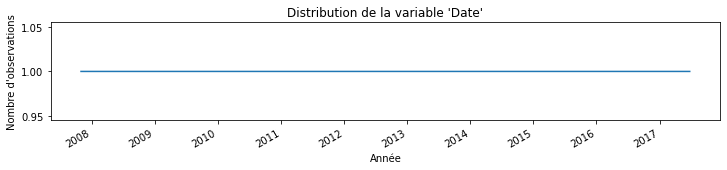

In [1372]:
# affichage de la distribution de la variable 'Date'
plt.figure(figsize=(12,2))
df_rain.groupby(['Date']).size().plot()
plt.title("Distribution de la variable 'Date'", fontsize=12)
plt.xlabel("Année")
plt.ylabel("Nombre d'observations");

- le jeu de données sélectionné relatif aux précipitations sur la ville de **Canberra** couvre bien toute la période considérée.

In [1373]:
# calcul de la moyenne mobile centrée sur une année
df_rain_ma_week = df_rain.rolling(window='7D', center=True).mean()

In [1374]:
# calcul de la moyenne mobile centrée sur une année
df_rain_ma_month = df_rain.rolling(window='30D', center=True).mean()

In [1375]:
# calcul de la moyenne mobile centrée sur une année
df_rain_ma_year = df_rain.rolling(window='365D', center=True).mean()

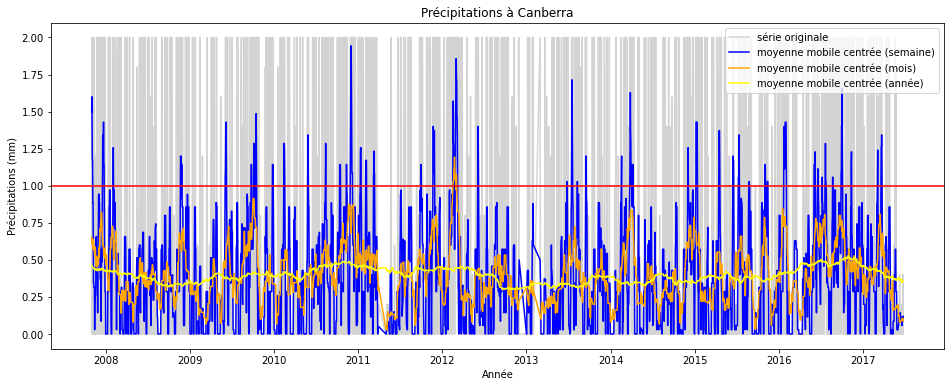

In [1376]:
# affichage de la série temporelle originale et des moyenne mobiles centrées
plt.figure(figsize=(16,6))
plt.plot(df_rain, color='lightgray', label='série originale')
plt.plot(df_rain_ma_week, color='blue', label='moyenne mobile centrée (semaine)')
plt.plot(df_rain_ma_month, color='orange', label='moyenne mobile centrée (mois)')
plt.plot(df_rain_ma_year, color='yellow', label='moyenne mobile centrée (année)')
plt.xlabel("Année")
plt.ylabel("Précipitations (mm)")
plt.axhline(y=1, color='red')
plt.legend(loc='upper right')
plt.title("Précipitations à Canberra");

- la moyenne mobile centrée sur une année permet d'identifier la tendance de la série originale qui est relativement constante au cours du temps.

In [1377]:
# détection des valeurs manquantes dans la série obtenue par moyenne mobile centrée sur une semaine
df_rain_ma_week.isna().sum()

0

In [1378]:
# détection des valeurs manquantes dans la série obtenue par moyenne mobile centrée sur un mois
df_rain_ma_month.isna().sum()

0

In [1379]:
# détection des valeurs manquantes dans la série obtenue par moyenne mobile centrée sur une année
df_rain_ma_year.isna().sum()

0

In [1380]:
# différence entre la série originale et la moyenne mobile centrée sur une année
df_rain_wo_ma = df_rain - df_rain_ma_year

In [1381]:
# conversion de la série "df_rain_wo_ma" en DataFrame
df = df_rain_wo_ma.to_frame()

In [1382]:
# taille du DataFrame "df"
df.shape

(3402, 1)

In [1383]:
# ajout de la colonne "month" au DataFrame "df_rain_wo_ma"
df["month"] = (df.index).month
df.head()

,Rainfall,month
Date,,
2007-11-01,-0.462295,11
2007-11-02,1.540217,11
2007-11-03,1.542703,11
2007-11-04,1.545161,11
2007-11-05,1.547594,11


In [1384]:
# calcul de la moyenne par mois de "df_rain_wo_ma"
seasonality = df.groupby("month").mean()
seasonality

,Rainfall
month,
1,-0.056120
2,0.043235
3,0.014652
4,-0.039769
5,-0.190258
6,0.008653
7,0.035792
8,0.023770
9,0.003214


In [1385]:
# calcul du coefficient saisonnier centré par soustraction de moyenne générale de la série
seasonality = seasonality - seasonality.mean()

In [1386]:
# ré-échantillonage de la série temporelle originale moyennée sur une période d'un mois
# et remplacement des valeurs manquantes par propagation de la dernière observation valide 
df_rain_month = df_rain.resample('M').mean().ffill()

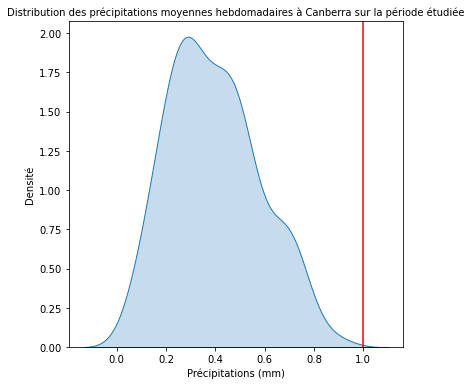

In [1387]:
# distribution des précipitations moyennes hebdomadaires à Canberra sur la période étudiée
plt.figure(figsize=(6,6))
sns.kdeplot(df_rain_month, shade='True')
plt.xlabel("Précipitations (mm)")
plt.ylabel("Densité")
plt.axvline(x=1, color='red')
plt.title("Distribution des précipitations moyennes hebdomadaires à Canberra sur la période étudiée", fontsize=10);

In [1389]:
# taille du DataFrame
df_rain_month.shape

(116,)

In [1390]:
# index du DataFrame
df_rain_month.index

DatetimeIndex(['2007-11-30', '2007-12-31', '2008-01-31', '2008-02-29',
               '2008-03-31', '2008-04-30', '2008-05-31', '2008-06-30',
               '2008-07-31', '2008-08-31',
               ...
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30'],
              dtype='datetime64[ns]', name='Date', length=116, freq='M')

In [1391]:
# ajout de la colonne "year" au DataFrame
df_rain_month = df_rain_month.to_frame()
df_rain_month['year'] = (df_rain_month.index).year
df_rain_month.head()

,Rainfall,year
Date,,
2007-11-30,0.520000,2007
2007-12-31,0.780645,2007
2008-01-31,0.348387,2008
2008-02-29,0.648276,2008
2008-03-31,0.219355,2008


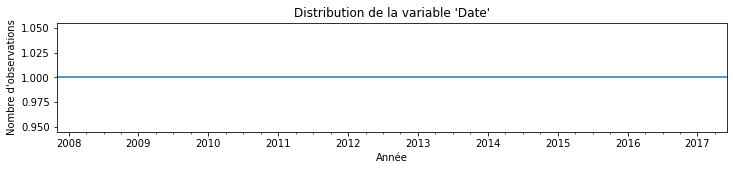

In [1392]:
# affichage de la distribution de la variable 'Date'
plt.figure(figsize=(12,2))
df_rain_month.groupby(['Date']).size().plot()
plt.title("Distribution de la variable 'Date'", fontsize=12)
plt.xlabel("Année")
plt.ylabel("Nombre d'observations");

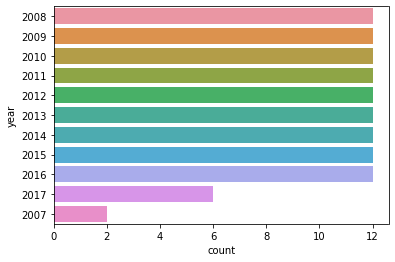

In [1393]:
# affichage de la répartition du jeu de données selon les années 
sns.countplot(y=df_rain_month['year'], order=df_rain_month['year'].value_counts().index);

In [1394]:
# sélection de 9 années entières uniquement
df_rain_month = df_rain_month.loc[pd.to_datetime('2008-01-31'):pd.to_datetime('2016-12-31')]

In [1395]:
# index du DataFrame
df_rain_month.index

DatetimeIndex(['2008-01-31', '2008-02-29', '2008-03-31', '2008-04-30',
               '2008-05-31', '2008-06-30', '2008-07-31', '2008-08-31',
               '2008-09-30', '2008-10-31',
               ...
               '2016-03-31', '2016-04-30', '2016-05-31', '2016-06-30',
               '2016-07-31', '2016-08-31', '2016-09-30', '2016-10-31',
               '2016-11-30', '2016-12-31'],
              dtype='datetime64[ns]', name='Date', length=108, freq='M')

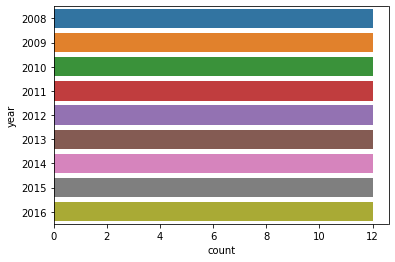

In [1399]:
# affichage de la répartition du jeu de données selon les années 
sns.countplot(y=df_rain_month['year'], order=df_rain_month['year'].value_counts().index);

In [1400]:
# suppression de la colonne "year" au DataFrame "df_rain_month"
df_rain_month.drop('year', axis=1, inplace=True)

In [1401]:
# aperçu du DataFrame "df_rain_month"
df_rain_month.head()

,Rainfall
Date,
2008-01-31,0.348387
2008-02-29,0.648276
2008-03-31,0.219355
2008-04-30,0.280000
2008-05-31,0.251613


In [1402]:
# taille du DataFrame "df_rain_month"
df_rain_month.shape

(108, 1)

In [1403]:
# taille du DataFrame "seasonality"
seasonality.shape

(12, 1)

In [1404]:
# soustraction des coefficients saisonniers à la série pour obtenir une série corrigée de ses variations saisonnières
seasonal_vector = np.zeros(108)

j=0
for i in range(9):
    seasonal_vector[j:j+12] = seasonality.iloc[:,0]
    j+=12

df_rain_cvs = df_rain_month['Rainfall'] - seasonal_vector

In [1407]:
# affichage de l'index
print(df_rain_cvs.index)

DatetimeIndex(['2008-01-31', '2008-02-29', '2008-03-31', '2008-04-30',
               '2008-05-31', '2008-06-30', '2008-07-31', '2008-08-31',
               '2008-09-30', '2008-10-31',
               ...
               '2016-03-31', '2016-04-30', '2016-05-31', '2016-06-30',
               '2016-07-31', '2016-08-31', '2016-09-30', '2016-10-31',
               '2016-11-30', '2016-12-31'],
              dtype='datetime64[ns]', name='Date', length=108, freq='M')


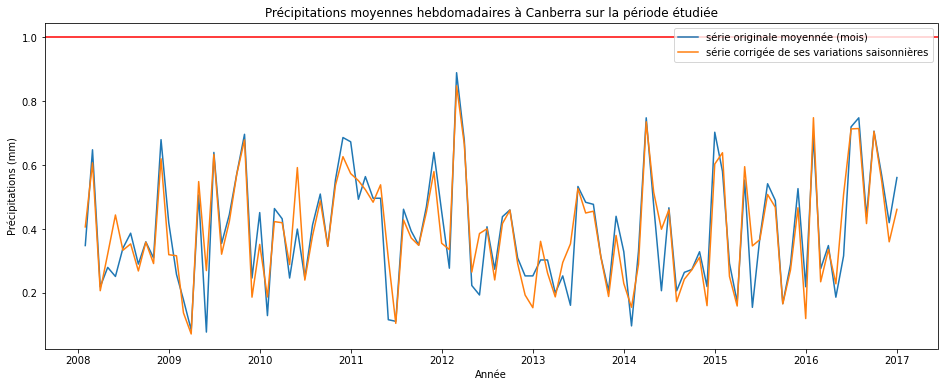

In [1408]:
# affichage de la série temporelle originale moyennée sur une période d'un mois 
# et de la série corrigée de ses variations saisonnières
plt.figure(figsize=(16,6))
plt.plot(df_rain_month, label='série originale moyennée (mois)')
plt.plot(df_rain_cvs, label='série corrigée de ses variations saisonnières')
plt.xlabel("Année")
plt.ylabel("Précipitations (mm)")
plt.axhline(y=1, color='red')
plt.legend(loc='upper right')
plt.title("Précipitations moyennes hebdomadaires à Canberra sur la période étudiée");

In [1409]:
# ré-échantillonage de la série temporelle originale moyennée sur une période d'une semaine
# et remplacement des valeurs manquantes par propagation de la dernière observation valide 
df_rain_week = df_rain.resample('W').mean().ffill()

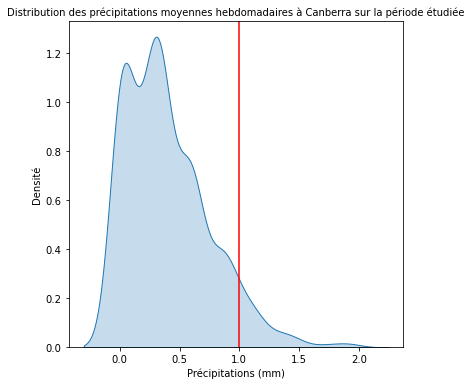

In [1410]:
# distribution des précipitations moyennes hebdomadaires à Canberra sur la période étudiée
plt.figure(figsize=(6,6))
sns.kdeplot(df_rain_week, shade='True')
plt.xlabel("Précipitations (mm)")
plt.ylabel("Densité")
plt.axvline(x=1, color='red')
plt.title("Distribution des précipitations moyennes hebdomadaires à Canberra sur la période étudiée", fontsize=10);

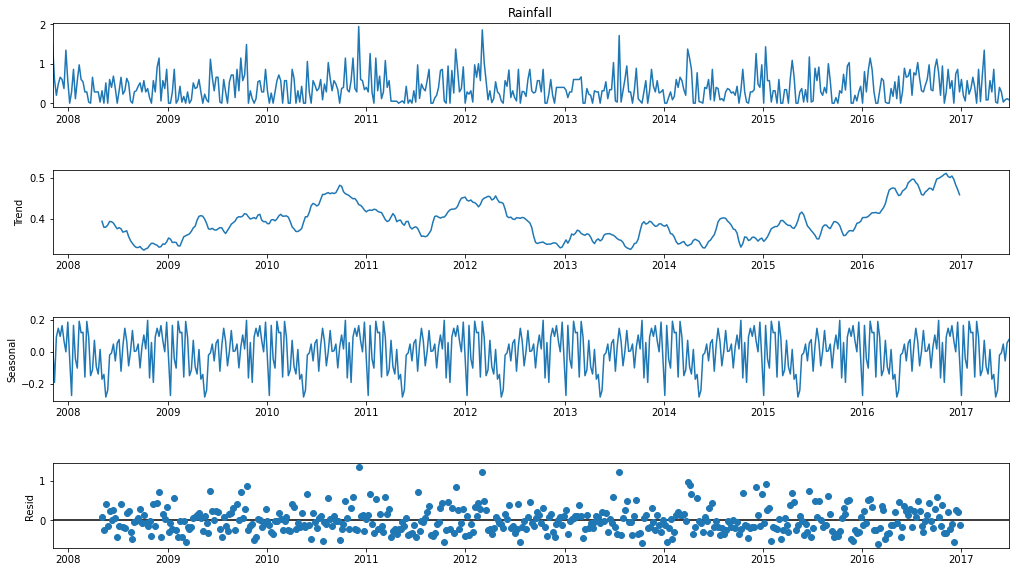

In [1411]:
# Décomposition automatique de la série temporelle identifiant la tendance, la saisonalité et le résidu
res = seasonal_decompose(df_rain_week, period=52, model='additive')
fig = res.plot()
fig.set_size_inches((16, 9));

- La tendance met en évidence les années de faibles et fortes précipitation,
- La saisonalité conserve une ampleur constante au cours du temps et correspond à un phénomène de période annuelle (soit 52 semaines environ),
- Le résidu ne présente pas de grandes variations en fonction du temps, il peut être assimilé à une suite de variables aléatoires non corrélées et de variance finie, c'est à dire à un bruit blanc faible.

In [1412]:
# soustraction des coefficients saisonniers à la série originale
x_cvs = df_rain_week - res.seasonal

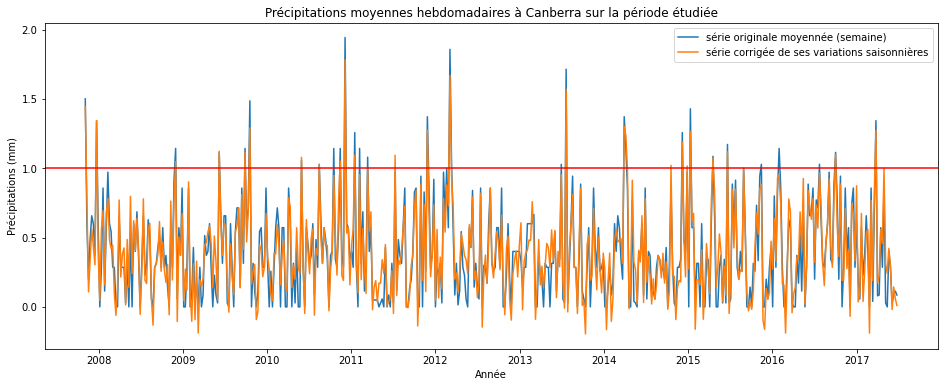

In [1413]:
# affichage de la série temporelle originale moyennée sur une période d'une semaine
# et de la série corrigée de ses variations saisonnières
plt.figure(figsize=(16,6))
plt.plot(df_rain_week, label='série originale moyennée (semaine)')
plt.plot(x_cvs, label='série corrigée de ses variations saisonnières')
plt.xlabel("Année")
plt.ylabel("Précipitations (mm)")
plt.axhline(y=1, color='red')
plt.legend(loc='upper right')
plt.title("Précipitations moyennes hebdomadaires à Canberra sur la période étudiée");

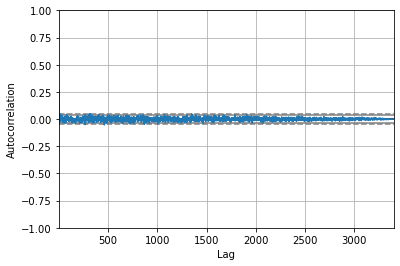

In [1414]:
# fonction d'autocorrélation de la série de données originale
pd.plotting.autocorrelation_plot(df_rain);

- l'autocorrélation tend vers 0 mais la décroissance de la fonction d'autocorrélation est relativement lente

In [1415]:
# différentiation d'ordre 1 sur la série temporelle originale afin de voir si cela permet de la stationnariser
df_rain_1 = df_rain.diff().dropna()

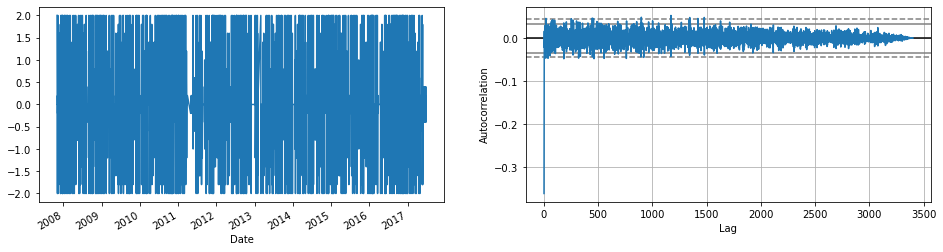

In [1429]:
# affichage de la série temporelle différenciée et de sa fonction d'autocorrélation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
df_rain_1.plot(ax=ax1)
pd.plotting.autocorrelation_plot(df_rain_1, ax=ax2);

- l'autocorrélation simple tend vers 0 mais la série n'est pas stationnaire car la saisonalité empêche encore une décroissance rapide vers 0.

In [1423]:
# test augmenté de Dickey-Fuller à la série différenciée
_, p_value, _, _, _, _ = sm.tsa.stattools.adfuller(df_rain_1)
p_value

2.050436085314002e-30

- la p_value est inférieure à 5% donc nous pouvons rejeter l'hypothèse que la série n'est pas stationnaire et donc la considérer comme stationnaire.

In [1435]:
# différentiation en saisonalité sur "df_rain_1"
df_rain_2 = df_rain_1.diff(periods=365).dropna()

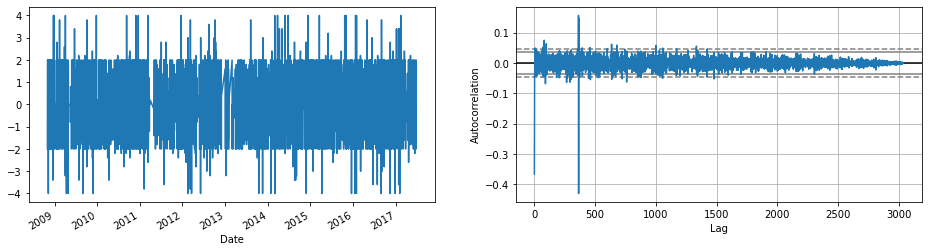

In [1436]:
# affichage de la série temporelle doublement différenciée et de sa fonction d'autocorrélation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
df_rain_2.plot(ax=ax1)
pd.plotting.autocorrelation_plot(df_rain_2, ax=ax2);

- les valeurs ne décroissent pas suffisamment rapidement pour que l'on puisse considérer la série comme stationnaire.
- la série doublement différenciée ne semble plus présenter de tendance ni de saisonalité.

In [1422]:
# test augmenté de Dickey-Fuller à la série doublement différenciée
_, p_value, _, _, _, _ = sm.tsa.stattools.adfuller(df_rain_2)
p_value

3.792699502474932e-30

- la p_value est inférieure à 5% donc nous pouvons rejeter l'hypothèse que la série n'est pas stationnaire et donc la considérer comme stationnaire.

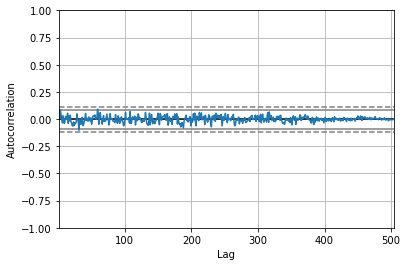

In [1346]:
# fonction d'autocorrélation de la série de données originale moyennée sur une semaine
pd.plotting.autocorrelation_plot(df_rain_week);

In [1424]:
# différentiation d'ordre 1 sur la série temporelle originale afin de voir si cela permet de la stationnariser
df_rain_week_1 = df_rain_week.diff().dropna()

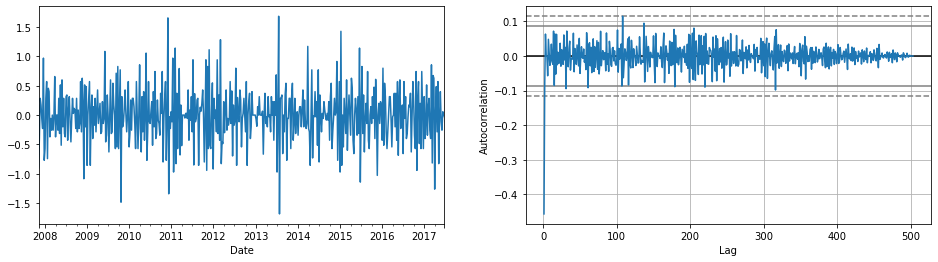

In [1427]:
# affichage de la série temporelle différenciée et de sa fonction d'autocorrélation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
df_rain_week_1.plot(ax=ax1)
pd.plotting.autocorrelation_plot(df_rain_week_1, ax=ax2);

- l'autocorrélation simple tend vers 0 mais la série n'est pas stationnaire car la saisonalité empêche encore une décroissance rapide vers 0.

In [1430]:
# test augmenté de Dickey-Fuller à la série différenciée
_, p_value, _, _, _, _ = sm.tsa.stattools.adfuller(df_rain_week_1)
p_value

2.7926707703680458e-15

- la p_value est inférieure à 5% donc nous pouvons rejeter l'hypothèse que la série n'est pas stationnaire et donc la considérer comme stationnaire.

In [1433]:
# différentiation en saisonalité sur "df_rain_1"
df_rain_week_2 = df_rain_week_1.diff(periods=52).dropna()

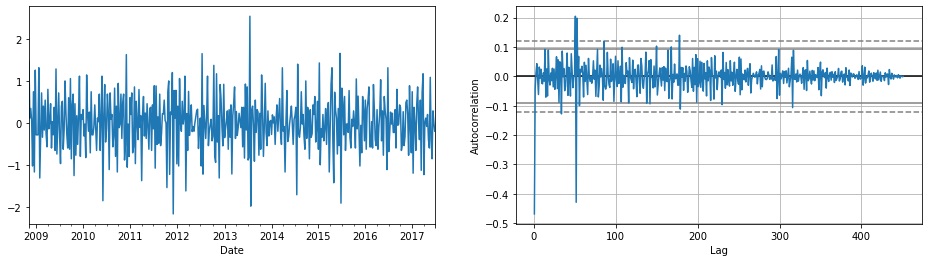

In [1437]:
# affichage de la série temporelle doublement différenciée et de sa fonction d'autocorrélation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
df_rain_week_2.plot(ax=ax1)
pd.plotting.autocorrelation_plot(df_rain_week_2, ax=ax2);

- les valeurs ne décroissent pas suffisamment rapidement pour que l'on puisse considérer la série comme stationnaire.
- la série doublement différenciée ne semble plus présenter de tendance ni de saisonalité.

In [1438]:
# test augmenté de Dickey-Fuller à la série doublement différenciée
_, p_value, _, _, _, _ = sm.tsa.stattools.adfuller(df_rain_week_2)
p_value

1.3327255301055028e-14

- la p_value est inférieure à 5% donc nous pouvons rejeter l'hypothèse que la série n'est pas stationnaire et donc la considérer comme stationnaire.

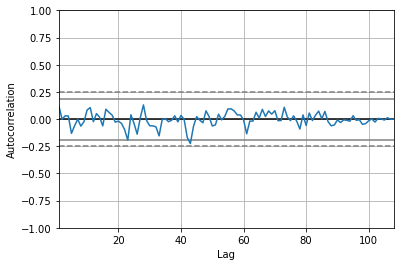

In [1439]:
# fonction d'autocorrélation de la série de données originale moyennée sur un mois
pd.plotting.autocorrelation_plot(df_rain_month);

In [1440]:
# différentiation d'ordre 1 sur la série temporelle originale afin de voir si cela permet de la stationnariser
df_rain_month_1 = df_rain_month.diff().dropna()

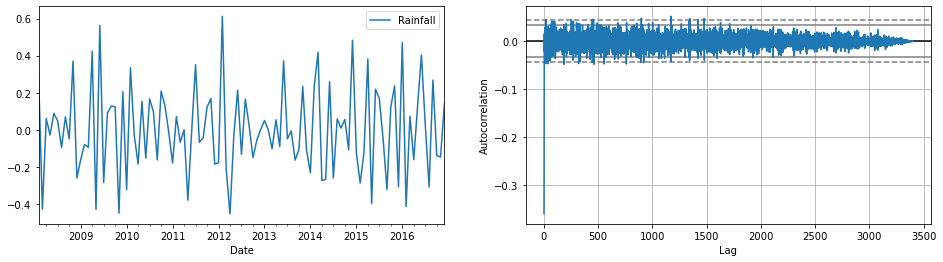

In [1441]:
# affichage de la série temporelle différenciée et de sa fonction d'autocorrélation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
df_rain_month_1.plot(ax=ax1)
pd.plotting.autocorrelation_plot(df_rain_1, ax=ax2);

- l'autocorrélation simple tend vers 0 mais la série n'est pas stationnaire car la saisonalité empêche encore une décroissance rapide vers 0.

In [1442]:
# test augmenté de Dickey-Fuller à la série différenciée
_, p_value, _, _, _, _ = sm.tsa.stattools.adfuller(df_rain_month_1)
p_value

1.4455362299270434e-09

- la p_value est inférieure à 5% donc nous pouvons rejeter l'hypothèse que la série n'est pas stationnaire et donc la considérer comme stationnaire.

In [1443]:
# différentiation en saisonalité sur "df_rain_1"
df_rain_month_2 = df_rain_month_1.diff(periods=12).dropna()

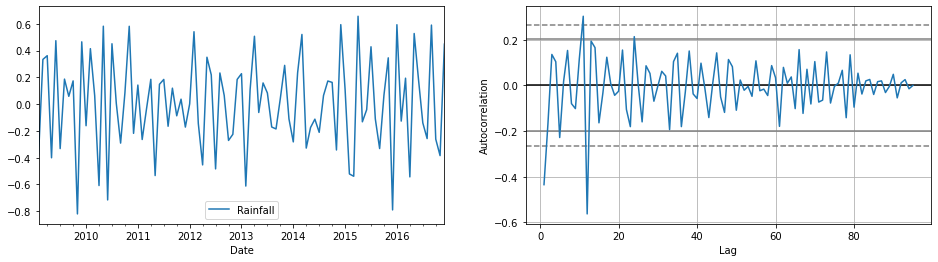

In [1444]:
# affichage de la série temporelle doublement différenciée et de sa fonction d'autocorrélation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
df_rain_month_2.plot(ax=ax1)
pd.plotting.autocorrelation_plot(df_rain_month_2, ax=ax2);

- les valeurs ne décroissent pas suffisamment rapidement pour que l'on puisse considérer la série comme stationnaire.
- la série doublement différenciée ne semble plus présenter de tendance ni de saisonalité.

In [1445]:
# test augmenté de Dickey-Fuller à la série doublement différenciée
_, p_value, _, _, _, _ = sm.tsa.stattools.adfuller(df_rain_month_2)
p_value

0.001474309405930932

- la p_value est inférieure à 5% donc nous pouvons rejeter l'hypothèse que la série n'est pas stationnaire et donc la considérer comme stationnaire.

Les 7 derniers jours de l'ensemble de données à partir de Juin 2017 sont retenus comme ensemble de données de test et ces pas de temps seront traités comme hors échantillon.

In [117]:
# séparation de la série en deux parties: données d'entraînement et de test
train, test = df_rain.loc[:pd.to_datetime('2017-06-19')], df_rain.loc[pd.to_datetime('2017-06-19'):]

print("Taille des données d'entraînement: %d \n Taille des données de test: %d" % (len(train), len(test)))

Taille des données d'entraînement: 3396 
 Taille des données de test: 7


In [118]:
# index du jeu d'entrainement
train.index

DatetimeIndex(['2007-11-01', '2007-11-02', '2007-11-03', '2007-11-04',
               '2007-11-05', '2007-11-06', '2007-11-07', '2007-11-08',
               '2007-11-09', '2007-11-10',
               ...
               '2017-06-10', '2017-06-11', '2017-06-12', '2017-06-13',
               '2017-06-14', '2017-06-15', '2017-06-16', '2017-06-17',
               '2017-06-18', '2017-06-19'],
              dtype='datetime64[ns]', name='Date', length=3396, freq=None)

In [119]:
# index du jeu de test
test.index

DatetimeIndex(['2017-06-19', '2017-06-20', '2017-06-21', '2017-06-22',
               '2017-06-23', '2017-06-24', '2017-06-25'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [120]:
# création des fichiers de données
train.to_csv('data/rainfall_train.csv', index=False)
test.to_csv('data/rainfall_test.csv', index=False)

- La dernière observation dans le fichier "rainfall_train.csv" est le **18 Juin 2017**. 
- Cela signifie que le **19 Juin 2017** et au-delà sont des pas de temps hors échantillon pour un modèle formé sur "rainfall_train.csv".

## Définition d'un modèle SARIMA

In [137]:
# chargement des données d'entraînement
series_train = pd.read_csv('data/rainfall_train.csv', header=0)

In [122]:
# chargement des données de test
series_test = pd.read_csv('data/rainfall_test.csv', header=0)

In [123]:
# différentiation d'ordre 1 sur la série temporelle originale afin de voir si cela permet de la stationnariser
series_train_1 = series_train.diff().dropna()

In [124]:
# différentiation en saisonalité sur "df_rain_1"
series_train_2 = series_train_1.diff(periods=365).dropna()

C:\Users\charlesj\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


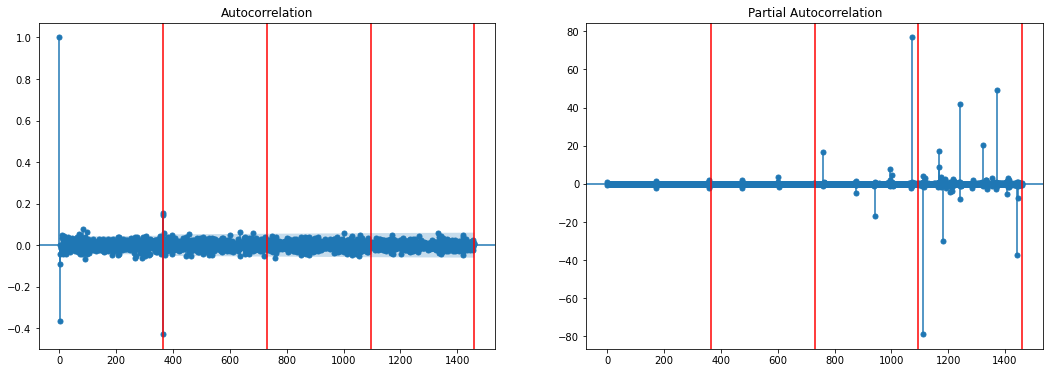

In [125]:
# visualisation sur 365*4 décalages les autocorrélogrammes simple et partiel de la série doublement différenciée.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

plot_acf(series_train_2.iloc[:,0], lags=365*4, ax=ax1)
ax1.axvline(x= 365, color='red')
ax1.axvline(x= 365*2, color='red')
ax1.axvline(x= 365*3, color='red')
ax1.axvline(x= 365*4, color='red')
plot_pacf(series_train_2.iloc[:,0], lags=365*4, ax=ax2)
ax2.axvline(x= 365, color='red')
ax2.axvline(x= 365*2, color='red')
ax2.axvline(x= 365*3, color='red')
ax2.axvline(x= 365*4, color='red');

- nous avons déjà identifié une saisonalité de période 365 $(k=365)$. De plus, nous avons fait une différentiation simple $(d=1)$ et une différentiation saisonnière $(D=1)$ pour stationnariser notre série temporelle. Ainsi notre modèle sera de la forme $SARIMA(p,1,q)(P,1,Q)_{365}$.
- on remarque qu'à la fois l'autocorrélation simple et partielle tendent vers 0, il ne semble pas y avoir de coupure en particulier. On peut donc supposer un processus $ARMA(p,q)$. Nous allons donc commencer par estimer via un processus $ARMA(1,1)$ la partie non saisonnière de notre série temporelle.
- pour l'autocorrélation simple, on observe une forte valeur au $365^{ème}$ pic tandis que les pics suivants sont extrêmement faibles. Ainsi la règle sur l'ACF pour un processus $MA(1)$ est respectée.  
- pour l'autocorrélation partielle, le $365^{ème}$ pic est encore significatif tandis que les $730^{ème}$, $1095^{ème}$ et $1460^{ème}$ pics sont dans la limite de non-significativité. Il n'y a pas de coupure mais plutôt une décroissance. Ainsi la règle sur la PACF pour un processus $MA(1)$ est aussi respectée.
- ainsi pour les ordres $p$, $q$, $P$ et $Q$ nous avons:
    - une décroissance de l'ACF et de la PACF sans coupure nette : modèle $ARMA(1,1)$.
    - pour les pics saisonniers, une coupure de l'ACF après la première période et une décroissance de la PACF : modèle $MA(1)$.

Nous allons donc entraîner un modèle $SARIMA(1,1,1)(0,1,1)_{365}$

In [131]:
# considération d'un sous ensemble du jeu de données par soucis d'efficacité car le modèle SARIMA est incapable 
# de traiter le jeu de données dans son intégralité:
# "MemoryError: Unable to allocate 13.6 GiB for an array with shape (733, 733, 3396) and data type float64"
series_train[-2*365:].index

RangeIndex(start=2666, stop=3396, step=1)

In [132]:
series_train[-2*365:].size

730

In [135]:
# modification du type des données pour réduire la zone mémoire occupée 
series_train_reduced = series_train.astype(np.uint8)

In [136]:
# instantiation d'un modèle SARIMAX correspondant au modèle SARIMA(1,1,1)(0,1,1)_365
model = sm.tsa.SARIMAX(series_train_reduced[-2*365:], order=(1,1,1), seasonal_order=(0,1,1,365))
sarima = model.fit()
print(sarima.summary())

MemoryError: Unable to allocate 2.92 GiB for an array with shape (733, 733, 730) and data type float64

L'utilisation d'un modèle **SARIMAX** pose problème et nous empêche de conclure l'étude avec les 2 dernières cellules d'exécution ci-dessous.

Pour contourner ce problème, nous allons nous intéresser à l'étude d'un modèle **ARIMA** (cf. prochaine section).

In [ ]:
# affichage de la prédiction
pred = sarima.predict(3396,3404)
series_train_pred = pd.concat([series_train, pred])
plt.plot(series_train_pred)
plt.axvline(x=datetime.date(2017,6,19), color='red');

In [ ]:
# affichage de la prédiction avec intervalle de confiance
prediction = sarima.get_forecast(steps=7).summary_frame()  

fig, ax = plt.subplots(figsize=(16,5))
plt.plot(series_train)
prediction['mean'].plot(ax=ax, style='k--')
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1);

## Définition d'un modèle ARIMA

Les données ont une forte composante saisonnière annuelle. Nous pouvons rendre les données stationnaires en prenant la différence saisonnière. Autrement dit, nous pouvons prendre l'observation d'un jour et soustraire l'observation du même jour il y a un an. Cela se traduira par un ensemble de données stationnaire à partir duquel nous pourrons ajuster un modèle ARIMA simple.

In [138]:
# fonction de différentiation saisonnière
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)

Cette opération peut s'inverser en ajoutant la valeur de l'observation il y a un an. Nous devrons le faire pour toutes les prévisions faites par un modèle formé sur les données désaisonnalisées.

In [139]:
# fonction d'inversion de la différentiation saisonnière
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [140]:
# application de la différence saisonnière
X = series_train.values
days_in_year = 365
differenced = difference(X, days_in_year)

In [189]:
# ajustement du modèle ARIMA
model = ARIMA(differenced, order=(1,1,1))
arima = model.fit()

print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3031
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4350.093
Date:                Wed, 02 Nov 2022   AIC                           8706.186
Time:                        14:33:41   BIC                           8724.235
Sample:                             0   HQIC                          8712.675
                               - 3031                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2612      0.016     16.256      0.000       0.230       0.293
ma.L1         -1.0000      0.022    -46.231      0.000      -1.042      -0.958
sigma2         1.0315      0.032     32.064      0.0

- la $4^{ème}$ colonne indique la p-valeur pour la significativité de chaque paramètre. Ici nous voyons que tous les paramètres ont une p-valeur nulle. Nous pouvons donc considérer tous les paramètres comme significatifs dans le modèle.
- selon le test de **"Ljung-Box"**, on lit sur la ligne **Prob(Q)** que la p-valeur de ce test est de 0.94, donc on ne rejette pas l'hypothèse $H0$: "le résidu est un bruit blanc".
- selon le test de **"Jarque-Bera"**, on lit sur la ligne **Prob(JB)** que la p-valeur de ce test est nulle, donc on rejette l'hypothèse $H0$: "le résidu suit une distribution normale".
- le résidu vérifie les hypothèses que l'on a faite à priori. On peut donc conclure que le modèle $ARIMA(1,1,1)$ est satisfaisant. Nous allons maintenant utiliser ce modèle pour faire une prédiction à l'horizon d'une semaine sur les prévisions de pluie.

## Prévision hors échantillon en une étape: J+1

Les modèles **ARIMA** sont parfaits pour les prévisions en une étape.

Une prévision en une étape est une prévision de l'étape de temps suivante dans la séquence à partir des données disponibles utilisées pour ajuster le modèle.

Dans ce cas, nous sommes intéressés par une prévision en une étape du jour du **19 Juin 2017**.

### Utilisation de la fonction forecast()

Par défaut, la fonction **forecast()** d'un modèle **ARIMA** effectue une prévision hors échantillon en une seule étape. Le résultat de la fonction **forecast()** est un tableau contenant la valeur de la prévision, l'erreur standard de la prévision et les informations sur l'intervalle de confiance.

In [190]:
# prévision hors échantillon en une étape
forecast = arima.forecast()[0]

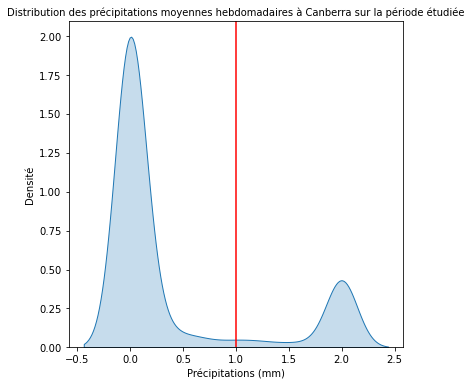

In [191]:
# distribution des précipitations moyennes hebdomadaires à Canberra sur la période étudiée
plt.figure(figsize=(6,6))
sns.kdeplot(df_rain, shade='True')
plt.xlabel("Précipitations (mm)")
plt.ylabel("Densité")
plt.axvline(x=1, color='red')
plt.title("Distribution des précipitations moyennes hebdomadaires à Canberra sur la période étudiée", fontsize=10);

Nous pouvons désormais inverser la différence saisonnière et reconvertir la valeur dans l'échelle d'origine.

In [192]:
# inversion de la différentiation saisonnière
forecast = inverse_difference(X, forecast, days_in_year)
print('Rainfall [forecast]: %f mm' % forecast)

Rainfall [forecast]: 0.207358 mm


Rainfall < 1 mm, ce qui signifierait que "RainTomorrow = No" pour le 18 Juin 2017.

In [193]:
# aperçu du DataFrame d'origine
df_city.head()

,Location,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta
Date,,,,,,,,,,,
2007-11-01,Canberra,0.0,6.3,30.0,29.0,1019.7,7.0,23.6,1,16.3,-39.0
2007-11-02,Canberra,2.0,9.7,39.0,36.0,1012.4,3.0,25.7,1,12.9,-44.0
2007-11-03,Canberra,2.0,3.3,73.5,69.0,1009.5,7.0,20.2,1,9.7,-13.0
2007-11-04,Canberra,2.0,9.1,54.0,56.0,1005.5,7.0,14.1,1,2.2,-6.0
2007-11-05,Canberra,2.0,10.6,50.0,49.0,1018.3,7.0,15.4,0,8.5,-19.0


In [194]:
df_city.loc['2017-06-19', 'Rainfall']

0.0

In [195]:
df_city.loc['2017-06-18', "RainTomorrow"]

0

Les prévisions sont correctes à J+1 sur l'ensemble de test.

### Utilisation de la fonction predict()

La fonction **predict()** d'un modèle **ARIMA** peut être utilisée pour prédire des pas de temps arbitraires dans l'échantillon et hors de l'échantillon, y compris le prochain pas de temps de prévision hors de l'échantillon.

La fonction de prédiction nécessite de spécifier un début et une fin, il peut s'agir des index des pas de temps relatifs au début des données d'apprentissage utilisées pour ajuster le modèle.

In [196]:
# prévision hors échantillon en une étape
start_index = len(differenced)
end_index = len(differenced)

forecast = arima.predict(start=start_index, end=end_index)

In [197]:
# inversion de la différentiation saisonnière
forecast = inverse_difference(X, forecast, days_in_year)
print('Rainfall [forecast]: %f mm' % forecast)

Rainfall [forecast]: 0.207358 mm


Nous retrouvons le même résultat qu'avec la méthode **Forecast()**, à savoir: Rainfall < 1 mm, ce qui signifierait que "RainTomorrow = No" pour le 18 Juin 2017.

In [198]:
df_city.loc['2017-06-19', 'Rainfall']

0.0

In [199]:
df_city.loc[pd.to_datetime('2017-06-18'), "RainTomorrow"]

0

La fonction **predict()** présente l'avantage d'être plus flexible que la méthode **Forecast()**. Il est possible de spécifier n'importe quel point ou intervalle de prévision contigu à l'intérieur ou à l'extérieur de l'échantillon.

## Prévision hors échantillon à plusieurs étapes: J+3, J+7

Il est possible de faire des prévisions en plusieurs étapes en utilisant les fonctions **forecast()** et **predict()** vues précédemment. 

### Utilisation de la fonction forecast()

La fonction **forecast()** a un argument appelé "steps" qui permet de spécifier le nombre de pas de temps à prévoir.

Par défaut, cet argument est défini sur 1 pour une prévision hors échantillon en une étape. Ici nous le réglons sur 7 pour obtenir une prévision pour les 7 prochains jours.

Nous pouvons ensuite inverser chaque pas de temps prévu, un à la fois et imprimer les valeurs. Pour inverser la valeur de prévision pour t+2, nous avons besoin de la valeur de prévision inversée pour t+1. Ici, nous les ajoutons à la fin d'une liste appelée "history" à utiliser lors de l'appel **inverse_difference()**.

In [200]:
# fonction de différentiation saisonnière
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)

# fonction d'inversion de la différentiation saisonnière
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# chargement des données d'entraînement
series_train = pd.read_csv('data/rainfall_train.csv', header=0)

# application de la différence saisonnière
X = series_train.values
days_in_year = 365
differenced = difference(X, days_in_year)

# ajustement du modèle ARIMA
model = ARIMA(differenced, order=(1,1,1))
arima = model.fit()

# prévision hors échantillon à plusieurs étapes
forecast = arima.forecast(steps=7)

# inversion de la différentiation saisonnière
history = [x for x in X]
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    print('Day %d: %f' % (day, inverted))
    history.append(inverted)
    day += 1

Day 1: 0.207358
Day 2: 2.009280
Day 3: 2.009782
Day 4: 0.409913
Day 5: 2.009947
Day 6: 0.209956
Day 7: 1.009959


- à J+3 : Rainfall > 1 mm, ce qui signifierait que "RainTomorrow = Yes" pour le 20 Juin 2017.
- à J+7 : Rainfall = 1 mm, ce qui signifierait que "RainTomorrow = Yes/No" pour le 24 Juin 2017.

In [201]:
df_city.loc[pd.to_datetime('2017-06-21'), 'Rainfall']

0.2

In [202]:
df_city.loc[pd.to_datetime('2017-06-20'), "RainTomorrow"]

0

In [203]:
df_city.loc[pd.to_datetime('2017-06-25'), "Rainfall"]

0.0

In [204]:
df_city.loc[pd.to_datetime('2017-06-24'), "RainTomorrow"]

0

### Utilisation de la fonction predict()

La fonction **predict()** peut également prévoir les 7 prochains pas de temps hors échantillon.

En utilisant des index de pas de temps, nous pouvons spécifier l'index de fin comme 6 pas de temps supplémentaires dans le futur.

In [205]:
# fonction de différentiation saisonnière
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)

# fonction d'inversion de la différentiation saisonnière
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# chargement des données d'entraînement
series_train = pd.read_csv('data/rainfall_train.csv', header=0)

# application de la différence saisonnière
X = series_train.values
days_in_year = 365
differenced = difference(X, days_in_year)

# ajustement du modèle ARIMA
model = ARIMA(differenced, order=(1,1,1))
arima = model.fit()

# prévision hors échantillon à plusieurs étapes
start_index = len(differenced)
end_index = start_index + 6

forecast = arima.predict(start=start_index, end=end_index)

# inversion de la différentiation saisonnière
history = [x for x in X]
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    print('Day %d: %f' % (day, inverted))
    history.append(inverted)
    day += 1

Day 1: 0.207358
Day 2: 2.009280
Day 3: 2.009782
Day 4: 0.409913
Day 5: 2.009947
Day 6: 0.209956
Day 7: 1.009959


L'appel à la méthode **predict()** produit les mêmes résultats que l'appel de la fonction **forecast()** dans la section précédente, à savoir:
- à J+3 : Rainfall > 1 mm, ce qui signifierait que "RainTomorrow = Yes" pour le 20 Juin 2017.
- à J+7 : Rainfall = 1 mm, ce qui signifierait que "RainTomorrow = Yes/No" pour le 24 Juin 2017.

In [206]:
df_city.loc[pd.to_datetime('2017-06-21'), 'Rainfall']

0.2

In [207]:
df_city.loc[pd.to_datetime('2017-06-20'), "RainTomorrow"]

0

In [208]:
df_city.loc[pd.to_datetime('2017-06-25'), "Rainfall"]

0.0

In [209]:
df_city.loc[pd.to_datetime('2017-06-24'), "RainTomorrow"]

0